In [32]:
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

In [34]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [35]:
train = datagen.flow_from_directory(
    r"D:\multi_model_project\face_emotion_detection\train",
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.


In [36]:
test = datagen.flow_from_directory(
    r"D:\multi_model_project\face_emotion_detection\test",
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [37]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 2
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 3
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 4
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())

# Dense Block
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Keep only after dense
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(7, activation='softmax'))


In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 21, 21, 128)      512       
 chNormalization)                                                
                                                      

In [39]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.save('model.h5')

In [41]:
import numpy as np
print(np.bincount(train.classes))
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 verbose=1,
                                 min_lr=1e-6)


[3995  436 4097 7215 4965 4830 3171]


In [42]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

class_weights = dict(enumerate(np.clip(weights, 0, 3.0)))
print(class_weights)

history = model.fit(train, epochs=30, validation_data=test, class_weight=class_weights)


{0: 1.0266046844269623, 1: 3.0, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}
Epoch 1/30
225/225 [==============================] - 44s 188ms/step - loss: 1.9425 - accuracy: 0.1895 - val_loss: 1.9441 - val_accuracy: 0.1718
Epoch 2/30
225/225 [==============================] - 32s 143ms/step - loss: 1.7094 - accuracy: 0.2491 - val_loss: 1.9306 - val_accuracy: 0.1740
Epoch 3/30
225/225 [==============================] - 26s 117ms/step - loss: 1.5911 - accuracy: 0.2956 - val_loss: 1.8094 - val_accuracy: 0.2027
Epoch 4/30
225/225 [==============================] - 20s 87ms/step - loss: 1.5240 - accuracy: 0.3479 - val_loss: 1.7482 - val_accuracy: 0.3167
Epoch 5/30
225/225 [==============================] - 22s 96ms/step - loss: 1.4476 - accuracy: 0.3945 - val_loss: 1.7663 - val_accuracy: 0.2655
Epoch 6/30
225/225 [==============================] - 23s 103ms/step - loss: 1.3871 - accuracy: 0.4279 - val_loss: 1.5757 - val_acc

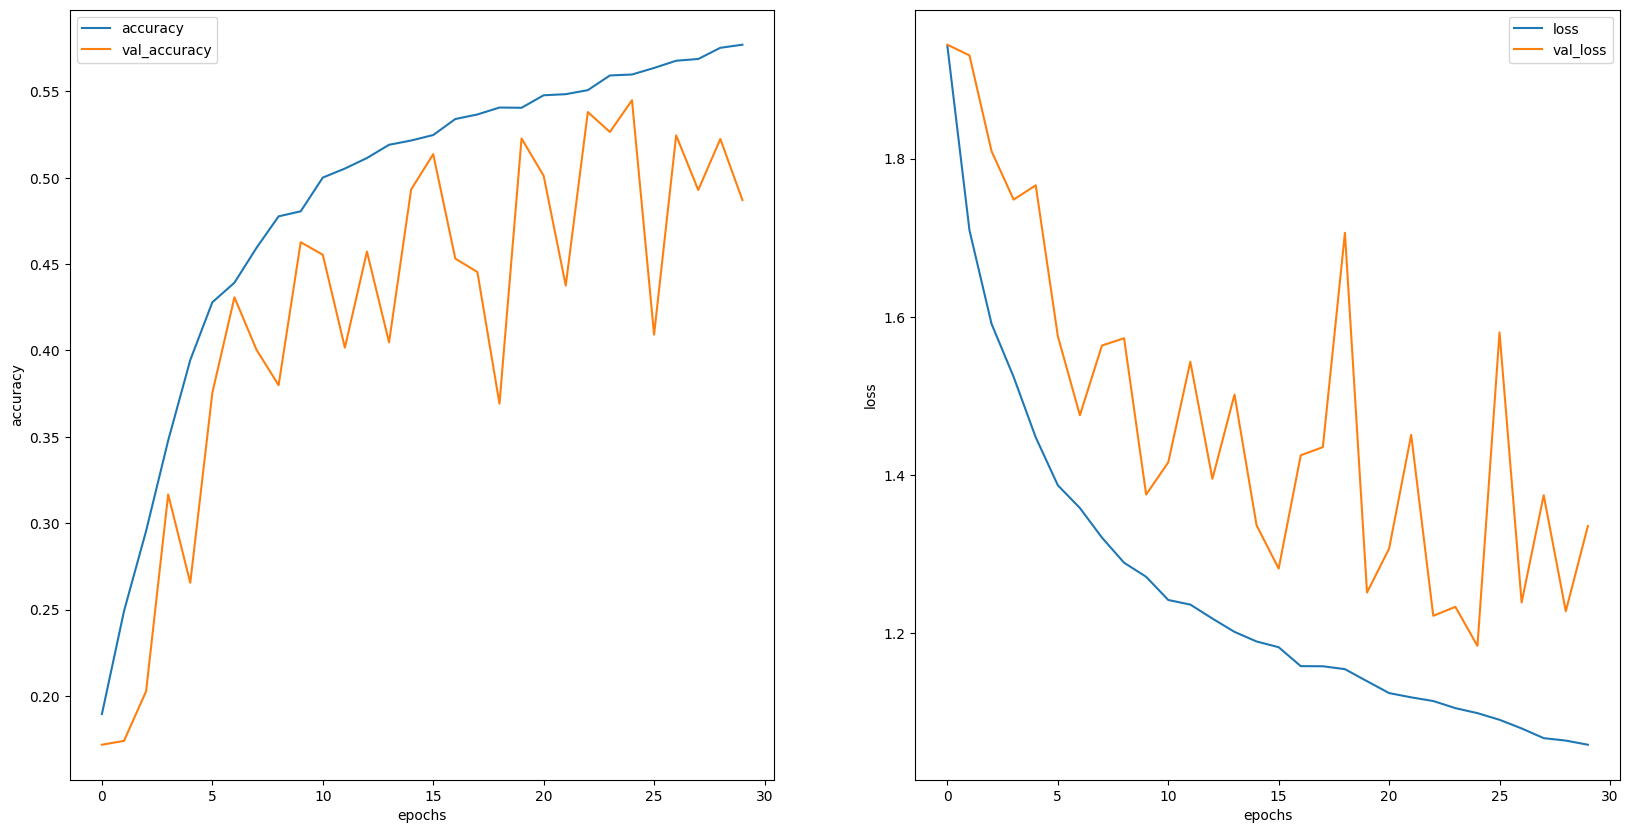

In [43]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

In [44]:
im = load_img(r"test/neutral/PublicTest_93816871.jpg", color_mode='grayscale', target_size=(48, 48))
im = img_to_array(im)               # Shape becomes (48, 48, 1)
im = np.expand_dims(im, axis=0)     # Shape becomes (1, 48, 48, 1)
im = im / 255.0                     # Normalize

pred = model.predict(im)
pred

1/1 [==============================] - 0s 200ms/step


array([[8.9677991e-03, 6.4560451e-04, 2.4546692e-02, 6.5983051e-01,
        2.4919893e-01, 1.3116966e-02, 4.3693498e-02]], dtype=float32)

In [45]:
emotion = ['angry','disgust','fear','happy','neutral','sad','surprise']

emotion[np.argmax(pred)]


'happy'